In [1]:
import numpy as np
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Resize,
    AddChannel,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import yaml
import sys
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/lobe_seg")
from dataloader import val_dataloader
from models import unet256, unet512
import pandas as pd
import nibabel as nib
sys.path.append("/home/local/VANDERBILT/litz/github/MASILab/thoraxtools")
import func.vis.vis as vis

In [2]:
CONFIG_PATH = "/home/local/VANDERBILT/litz/github/MASILab/lobe_seg/configs/Config_0403luna16.YAML"
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.load(file, Loader=yaml.FullLoader)
    return config

config = load_config(CONFIG_PATH)
config_id = "0403luna16"

In [ ]:
logs_dir = os.path.join(config["log_dir"], config_id)
loss_path = os.path.join(logs_dir, f"{config_id}_loss_20220313.1943")
train_dice_path = os.path.join(logs_dir, f"{config_id}_dice_20220313.1943")
dice_path = os.path.join(logs_dir, f"{config_id}_val_dice_20220313.1943")
val_loss_path = os.path.join(logs_dir, f"{config_id}_val_loss_20220313.1943")

def read_log(path):
    epochs= []
    metric = []
    with open(path) as f:
        for line in f:
            line = line.rstrip()
            line = line.split(",")
            epochs.append(int(line[0]))
            metric.append(float(line[1]))
    return (epochs, metric)

xloss, yloss = read_log(loss_path)
xtrain_dice, ytrain_dice = read_log(train_dice_path)
xdice, ydice = read_log(dice_path)
xval_loss, yval_loss = read_log(val_loss_path)


In [ ]:
for i in range(90, 100):
    print(i, ydice[i])

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
plt.xlabel("epoch")
plt.plot(xloss, yloss, label='Train Loss')
# plt.plot(xtrain_dice, ytrain_dice, label='Train dice')
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
plt.xlabel("epoch")
plt.plot(xdice, ydice, label='Val Dice')
plt.subplot(1,2,2)
plt.title("Val Dice/Loss")
plt.xlabel("epoch")
plt.plot(xval_loss, yval_loss, label='Val Loss')
plt.legend()
plt.show()

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = torch.device("cuda:0")

In [12]:
# unwrap directory paths
DATA_DIR = config["data_dir"]
MODEL_DIR = os.path.join(config["model_dir"], config_id)
model_path = os.path.join(MODEL_DIR, f"{config_id}_best_model.pth")

# Set randomness
set_determinism(seed=config["random_seed"])
# random.seed(config["random_seed"])

# Load data
images = sorted(glob.glob(os.path.join(DATA_DIR, config["image_type"])))
# Load data
val_loader = val_dataloader(config, images)

# Hyperparams
# N_SAMPLE = config["sample_size"]
LR = config["lr"]
EPOCHS = config["epochs"]
VAL_INTERVAL = config["val_interval"]  # Interval at which to compute validation metrics
NUM_CLASSES = 6
LABEL_SHAPE = (512, 512, 320)  # All labels have this shape, but input shapes vary

# Initialize Model, Loss, and Optimizer
set_determinism(seed=config["random_seed"])
model = unet512(NUM_CLASSES).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

Validation sample size: 36


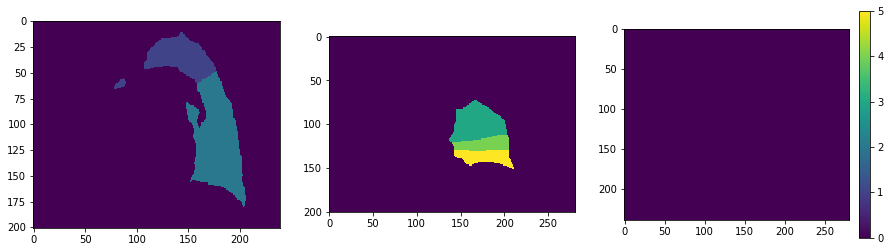

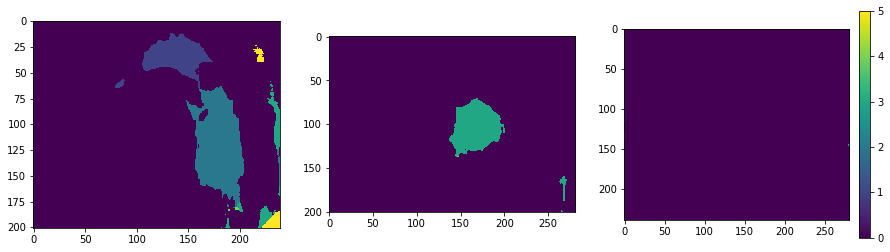

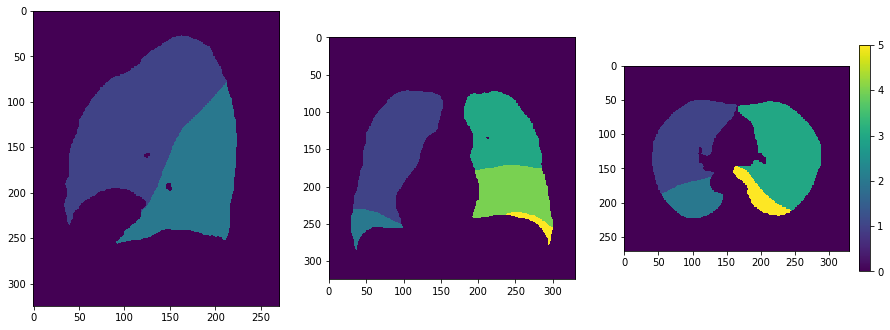

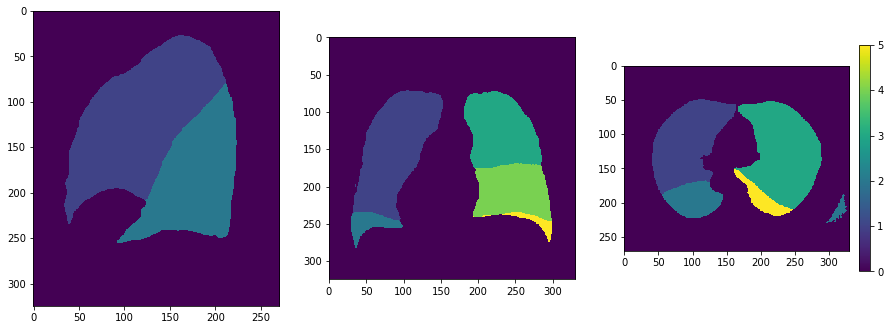

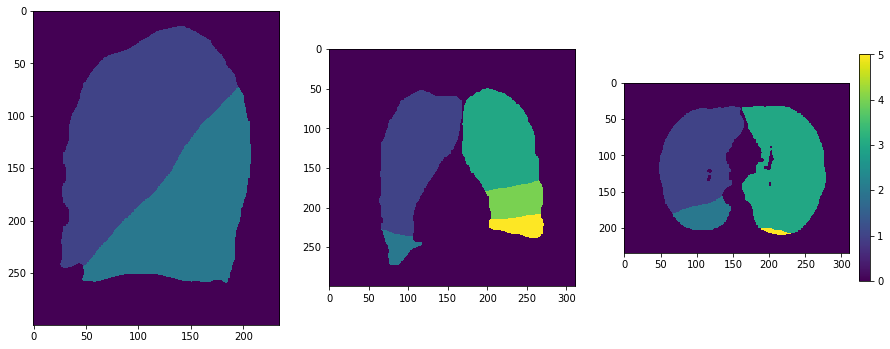

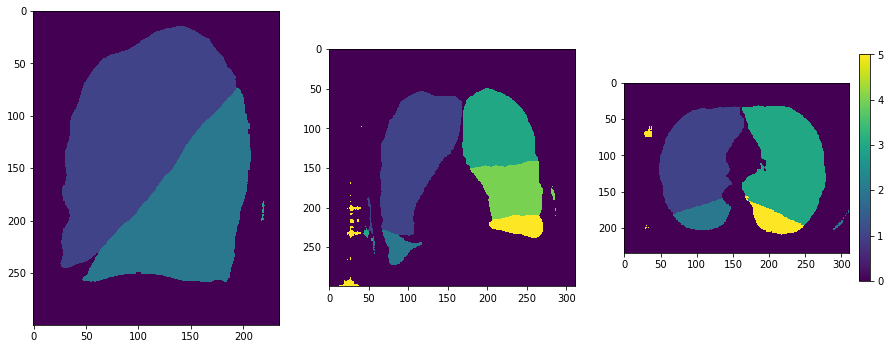

In [19]:
# Inspect best model
# best_model_path = os.path.join(MODEL_DIR, '0305_epoch69_best_model.pth')
# model.load_state_dict(torch.load(best_model_path))
# model.eval()
# examples = []

# Inspect recent epochs
checkpoint_path= os.path.join(config['checkpoint_dir'], config_id, 'epoch52.tar')
model.load_state_dict(torch.load(model_path))
model.eval()
examples = []

with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        if i >= 3:
            break
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)

        np_img = val_data["image"][0,0,:,:,:].detach().cpu().numpy()
        np_label = val_data["label"][0,0,:,:,:].detach().cpu().numpy()
        # showslice(np_img, 200, 200,200, is_gray=True)
        vis.showslice(np_label, 100, 180, 200)
        output = torch.argmax(val_outputs, dim=1)[0,:,:,:].detach().cpu().numpy()
        vis.showslice(output, 100, 180,200)
        plt.show()
        examples.append((np_img, np_label, output))

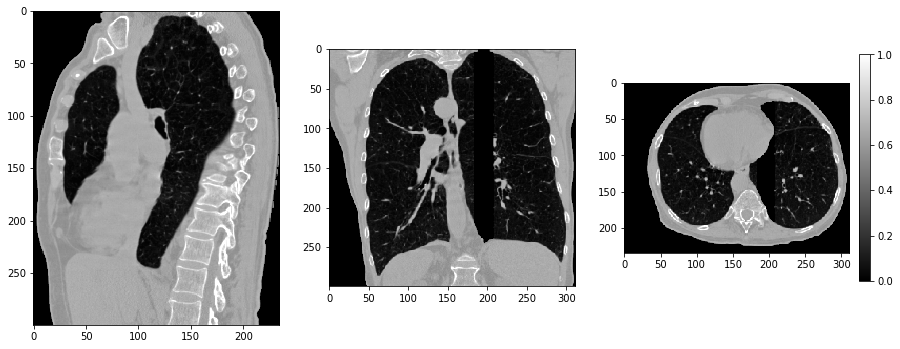

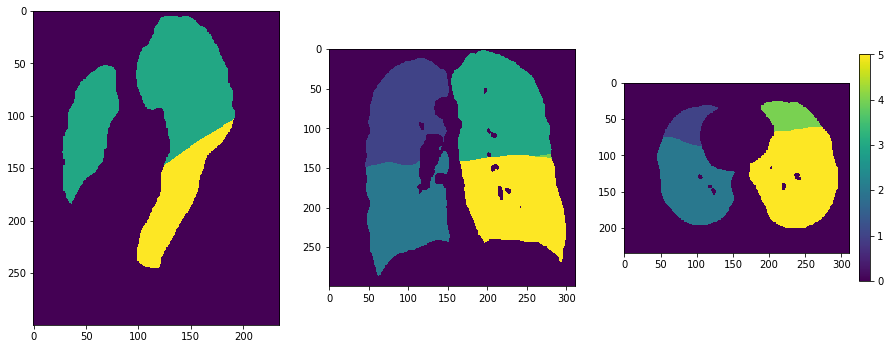

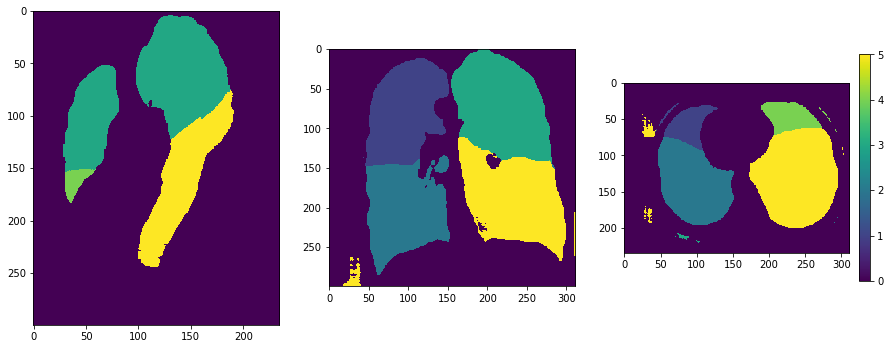

In [20]:
vis.showslice(np_img, 180, 100,100, is_gray=True)
vis.showslice(np_label, 180,100, 100)
vis.showslice(output, 180, 100,100)

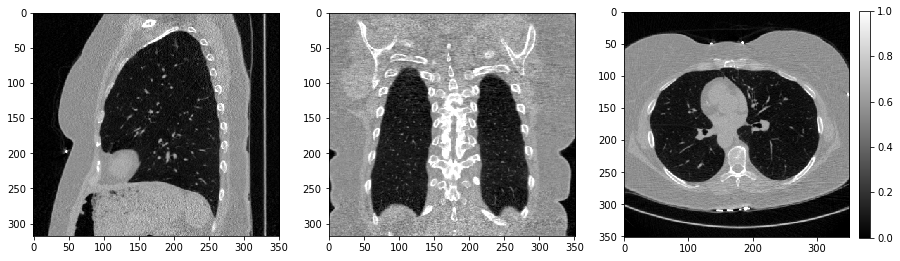

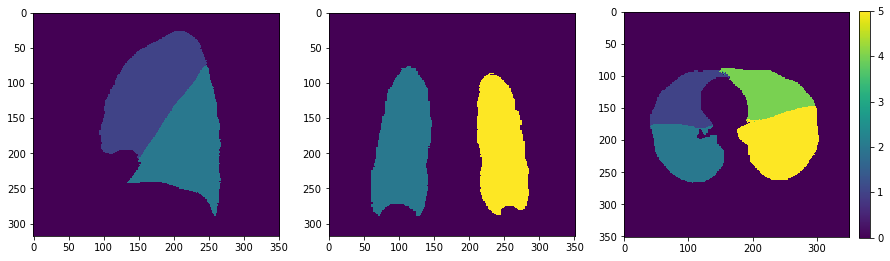

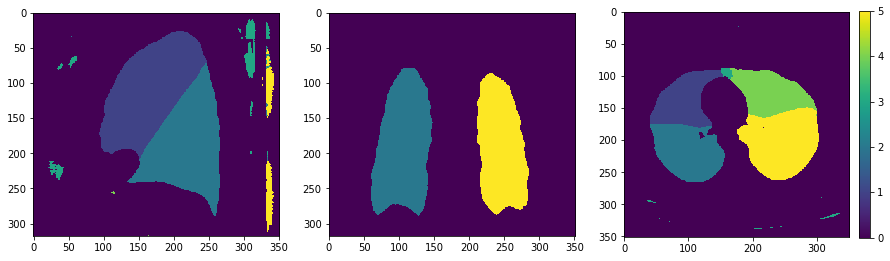

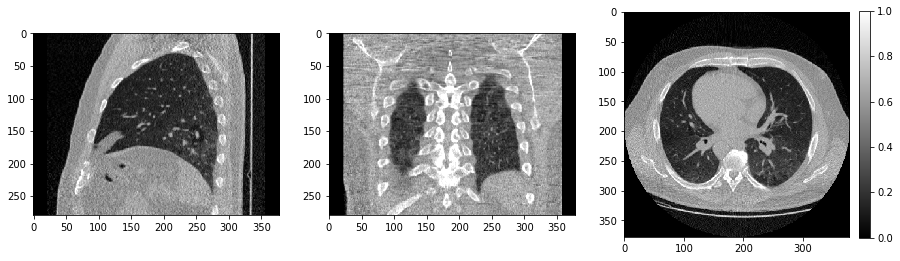

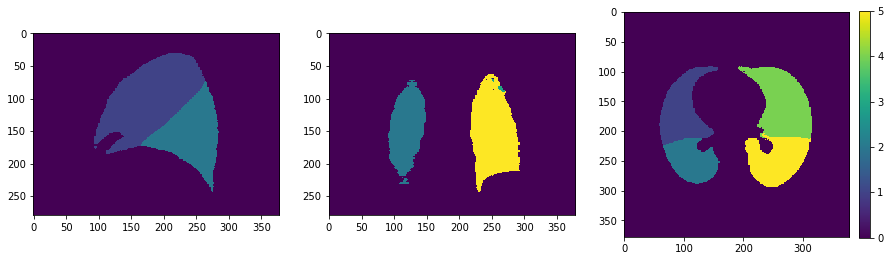

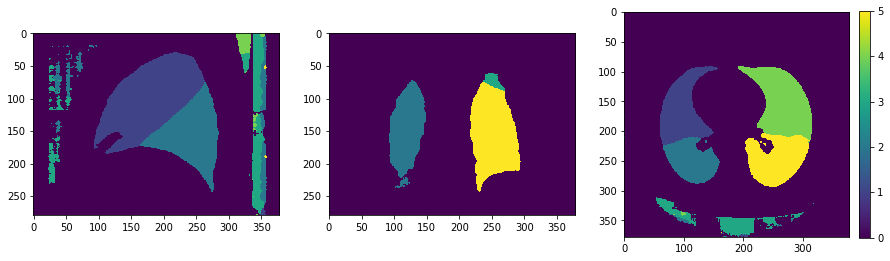

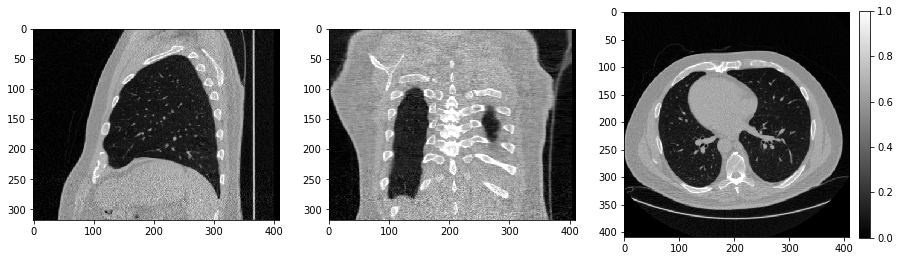

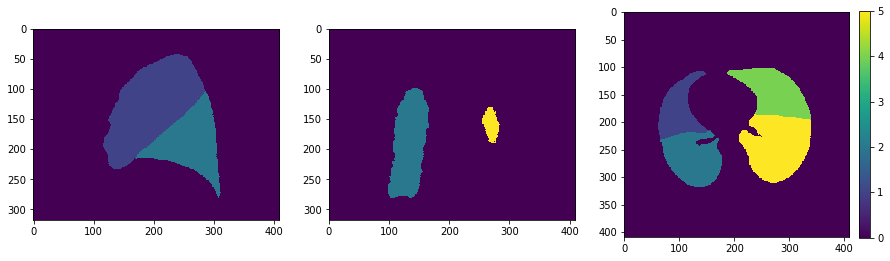

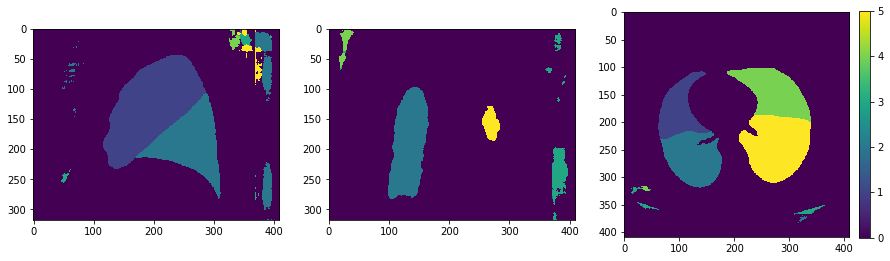

In [17]:

for i in range(3):
    vis.showslice(examples[i][0], 100, 100,150, is_gray=True)
    vis.showslice(examples[i][1], 100, 100, 150)
    vis.showslice(examples[i][2], 100, 100,150)